In [18]:
from gensim.similarities import SparseTermSimilarityMatrix, WordEmbeddingSimilarityIndex
import gensim.downloader as api
from gensim.corpora import Dictionary
from gensim.models import KeyedVectors
from gensim.models import TfidfModel
from gensim.similarities import SoftCosineSimilarity
import pandas as pd

#213B02D2-AA62-ED11-B67D-D85ED3AE4DFE
#AEF68502-AE62-ED11-B67D-D85ED3AE4DFE
#213B02D2-AA62-ED11-B67D-D85ED3AE4DFE
ChosenUser = "AEF68502-AE62-ED11-B67D-D85ED3AE4DFE"

df = pd.read_csv('./results4.csv')
df.columns = ['id', 'text', 'modText', 'sentiment', 'topics', 'hashtags']

for i in range(0, len(df)):
    df['topics'][i] = df['topics'][i].replace("'',", "")
df['topics'] = df['topics'].apply(lambda x: x[1:-1].split(', '))

userDF = pd.DataFrame(columns=['id', 'topics',])
userDF.id = df.id.unique()
#add all unique topics to userDF by id unless it is empty
for i in range(0, len(userDF)):
    userDF['topics'][i] = df[df['id'] == userDF['id'][i]]['topics'].sum()
    userDF['topics'][i] = [x for x in userDF['topics'][i] if x != "\'\'"]
    
userDF['topics'].to_csv('./test.csv', index=False)

#change sentiment 4 to 1
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 4 else x)

#for each topic add sentiment based on mean of sentiment of the user's tweets with that topic
for i in range(0, len(userDF)):
    for j in range(0, len(userDF['topics'][i])):
        userDF['topics'][i][j] = userDF['topics'][i][j] + str((df[(df['id'] == userDF['id'][i]) & (df['topics'].apply(lambda x: userDF['topics'][i][j] in x))]['sentiment'].mean()).round(2))

userDF['topicsRaw'] = pd.read_csv('./test.csv')['topics']

#convert array of topicsRaw to string
userDF['topicsRaw'] = userDF['topicsRaw'].apply(lambda x: str(x))

#clean topicsRaw and convert to array
userDF['topicsRaw'] = userDF['topicsRaw'].apply(lambda x: x.replace("\"", ""))
userDF['topicsRaw'] = userDF['topicsRaw'].apply(lambda x: x[1:-1].split(', '))

#using soft cosine similarity return 10 most similar users to a given user
fasttext_model300 = api.load('fasttext-wiki-news-subwords-300')
documents = userDF['topics']
dictionary = Dictionary(documents)
bow_corpus = [dictionary.doc2bow(doc) for doc in documents]
index = WordEmbeddingSimilarityIndex(fasttext_model300)
sims = SparseTermSimilarityMatrix(index, dictionary)
model = SoftCosineSimilarity(bow_corpus, sims, num_best=10)

def get_recommendations(id):
    idx = userDF.index[userDF['id'] == id][0]
    query = userDF['topics'][idx]
    query = dictionary.doc2bow(query)
    return model[query]

#get closest users to the given user to predict sentiment towards a topic
results = get_recommendations(ChosenUser)

#only use users with a distance of less than 0.3
results = [x for x in results if x[1] < 0.3]

#assign user{number} to each user
userDF['user'] = ["user" + str(i) for i in range(0, len(userDF))]
userDF['userNum'] = [str(i) for i in range(0, len(userDF))]

print("Closest users to", userDF.loc[userDF['id'] == ChosenUser, 'user'].iloc[0], "are:", [userDF['user'][x[0]] for x in results], "with distances of:", [x[1] for x in results])

#get the most common topic for these users which the given user has tweeted about
topic = max([x for y in [userDF['topicsRaw'][x] for x in [x[0] for x in results]] for x in y], key=[x for y in [userDF['topicsRaw'][x] for x in [x[0] for x in results]] for x in y].count)

#get mean sentiment of each of the closest users tweets with this topic
for i in range(0, len(results)):
    results[i] = (results[i][0], results[i][1], df[(df['id'] == userDF['id'][results[i][0]]) & (df['topics'].apply(lambda x: topic in x))]['sentiment'].mean())

#predict chosen user's sentiment towards the topic using the mean sentiment of the closest users tweets with the topic if not NAN
PredSentiment = sum([x[2] for x in results if not pd.isnull(x[2])]) / len([x[2] for x in results if not pd.isnull(x[2])])

print(topic, PredSentiment)

if(PredSentiment > 0.8):
    print("positive")
elif(PredSentiment > 0.6):
    print("mostly positive")
elif(PredSentiment > 0.4):
    print("neutral")
elif(PredSentiment > 0.2):
    print("mostly negative")
else:
    print("negative")

C:\Users\andre\AppData\Local\Temp\ipykernel_12212\3413785450.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 1483/1483 [00:00<00:00, 423658.41it/s]

Closest users to user13 are: ['user5', 'user12', 'user6', 'user11', 'user3', 'user7', 'user4', 'user8', 'user0'] with distances of: [0.08807240426540375, 0.08763093501329422, 0.08692812919616699, 0.08128863573074341, 0.07552555948495865, 0.06869648396968842, 0.065177783370018, 0.06426268815994263, 0.06009094417095184]
'Twitter' 0.3411890397184515
mostly negative



C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gensim\similarities\termsim.py:382: RuntimeWarning:

divide by zero encountered in divide

C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gensim\similarities\termsim.py:382: RuntimeWarning:

invalid value encountered in multiply



In [19]:
#list all unique ids
print(userDF.id.unique())

['DFD035A3-9B62-ED11-B67D-D85ED3AE4DFE'
 'F6D65BC0-9D62-ED11-B67D-D85ED3AE4DFE'
 'DBCEE0EF-9D62-ED11-B67D-D85ED3AE4DFE'
 '70CBBF4A-9E62-ED11-B67D-D85ED3AE4DFE'
 '1DB29AD5-A062-ED11-B67D-D85ED3AE4DFE'
 'B31A635D-A162-ED11-B67D-D85ED3AE4DFE'
 '4E8AB055-A962-ED11-B67D-D85ED3AE4DFE'
 '57B01778-A962-ED11-B67D-D85ED3AE4DFE'
 '64EA9B6D-AA62-ED11-B67D-D85ED3AE4DFE'
 '213B02D2-AA62-ED11-B67D-D85ED3AE4DFE'
 '84474B2C-AD62-ED11-B67D-D85ED3AE4DFE'
 '02E9AD93-AD62-ED11-B67D-D85ED3AE4DFE'
 'C3A88EB4-AD62-ED11-B67D-D85ED3AE4DFE'
 'AEF68502-AE62-ED11-B67D-D85ED3AE4DFE']


In [20]:
#plot a chart showing user Id, mean sentiment of tweets with topic, distance from given user, and number of tweets with topic

combDF = pd.DataFrame(results, columns=['user', 'distance', 'mean'])

import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(header=dict(values=['User', 'Mean Sentiment', 'Distance', 'Number of Tweets with Topic']),
                    cells=dict(values=[combDF['user'], combDF['mean'], combDF['distance'], [len(df[(df['id'] == userDF['id'][x]) & (df['topics'].apply(lambda x: topic in x))]) for x in combDF['user']]]))
                ])
fig.show()

In [21]:
#add close user id and mean sentiment to new dataframe and sort by id ascending

plotDf = pd.DataFrame(results, columns=['user', 'distance', 'meanSentiment'])

#copy results[0] to plotDf['user']

plotDf['index'] = [x[0] for x in results]

plotDf = plotDf.sort_values(by=['user'])

#remove from plotDf any users with NAN mean sentiment

plotDf = plotDf[~plotDf['meanSentiment'].isnull()]

#add 'user' before each user id

plotDf['user'] = ["user" + str(i) for i in plotDf['user']]

#graph showing the closest users and the given user and their sentiment towards the mean if not NAN. sort users by id

import plotly.express as px

fig = go.Figure()

fig.add_trace(go.Scatter(x=plotDf['user'], y=plotDf['meanSentiment'], mode='markers', name='Close Users'))
fig.add_trace(go.Scatter(x=[userDF.loc[userDF['id'] == ChosenUser, 'user'].iloc[0]], y=[PredSentiment], mode='markers', name='Chosen User'))

fig.update_layout(title='Mean and predicted user sentiment towards the \'{}\' topic'.format(topic), xaxis_title='User', yaxis_title='Mean Sentiment')

fig.show()


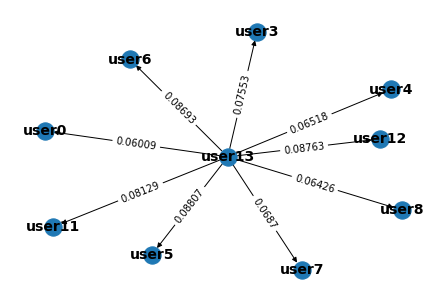

In [22]:
#directed graph showing the closest users to the given user and their distance from the given user

import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

G.add_node(userDF.loc[userDF['id'] == ChosenUser, 'user'].iloc[0])

for i in range(0, len(results)):
    G.add_node(userDF['user'][results[i][0]])
    G.add_edge(userDF.loc[userDF['id'] == ChosenUser, 'user'].iloc[0], userDF['user'][results[i][0]], weight=results[i][1].round(5))
    
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', font_size=14)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()

In [23]:
#plot a chart showing the closest users sentiment towards the topic over each tweet

import plotly.graph_objects as go

fig = go.Figure()

fig.update_layout(
    title="Sentiment towards " + topic + " by closest users to " + userDF.loc[userDF['id'] == ChosenUser, 'user'].iloc[0],
    xaxis_title="Tweet",
    yaxis_title="Sentiment",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

for i in range(0, len(results)):
    fig.add_trace(go.Scatter(x=[x for x in range(0, len(df[(df['id'] == userDF['id'][results[i][0]]) & (df['topics'].apply(lambda x: topic in x))]))], y=df[(df['id'] == userDF['id'][results[i][0]]) & (df['topics'].apply(lambda x: topic in x))]['sentiment'], mode='lines', name=userDF['user'][results[i][0]]))
    
fig.show()

In [24]:
#plot bar chart showing number of tweets with topic for each closest users. sort users by id

import plotly.express as px

fig = px.bar(plotDf, x='user', y=[len(df[(df['id'] == userDF['id'][x]) & (df['topics'].apply(lambda x: topic in x))]) for x in plotDf['index']], title='Number of tweets with the \'{}\' topic for each closest user to {}'.format(topic, userDF.loc[userDF['id'] == ChosenUser, 'user'].iloc[0]))

#add label to y axis
fig.update_yaxes(title_text='Number of tweets')

fig.show()

In [25]:
#calculate mean sentiment of the ChosenUser's tweets towards the topic

meanSentiment = df[(df['id'] == ChosenUser) & (df['topics'].apply(lambda x: topic in x))]['sentiment'].mean()

#plot a bar chart showing the mean sentiment of the ChosenUser's tweets towards the topic vs the predicted sentiment of the ChosenUser towards the topic

import plotly.graph_objects as go

fig = go.Figure()

fig.update_layout(
    title="Mean Sentiment of " + topic + " by " + userDF.loc[userDF['id'] == ChosenUser, 'user'].iloc[0],
    xaxis_title="Sentiment",
    yaxis_title="Number of tweets",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.add_trace(go.Bar(x=['Mean Sentiment', 'Predicted Sentiment'], y=[meanSentiment, PredSentiment]))

fig.show()

In [26]:
run1Mean = 0.305485893416928
run1Id = "DFD035A3-9B62-ED11-B67D-D85ED3AE4DFE"
run1Topic = "'EU'"
run1RealSentiment = df[(df['id'] == run1Id) & (df['topics'].apply(lambda x: run1Topic in x))]['sentiment'].mean()

run2Mean = 0.596342737722048
run2Id = "64EA9B6D-AA62-ED11-B67D-D85ED3AE4DFE"
run2Topic = "'EU'"
run2RealSentiment = df[(df['id'] == run2Id) & (df['topics'].apply(lambda x: run2Topic in x))]['sentiment'].mean()

run3Mean = 0.10587397352103234
run3Id = "213B02D2-AA62-ED11-B67D-D85ED3AE4DFE"
run3Topic = "'Twitter'"
run3RealSentiment = df[(df['id'] == run3Id) & (df['topics'].apply(lambda x: run3Topic in x))]['sentiment'].mean()

run4Mean = 0.3411890397184515
run4Id = "AEF68502-AE62-ED11-B67D-D85ED3AE4DFE"
run4Topic = "'Twitter'"
run4RealSentiment = df[(df['id'] == run4Id) & (df['topics'].apply(lambda x: run4Topic in x))]['sentiment'].mean()

#calculate error between mean sentiment and predicted sentiment
error = abs(meanSentiment - PredSentiment)
print("Error: " + str(error))

#calculate standard error
import math

standardError = math.sqrt((error**2))
print("Standard Error: " + str(standardError))

#calculate mean absolute error
meanAbsoluteError = (abs(run1RealSentiment - run1Mean) + abs(run2RealSentiment - run2Mean) + abs(run3RealSentiment - run3Mean) + abs(run4RealSentiment - run4Mean))/4
print("Mean Absolute Error: " + str(meanAbsoluteError))

#calculate mann whitney u test between mean sentiment and predicted sentiment of all runs
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu([run1Mean, run2Mean, run3Mean, run4Mean], [run1RealSentiment, run2RealSentiment, run3RealSentiment, run4RealSentiment])

print('Statistics=%.3f, p=%.3f' % (stat, p))

#interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')
    

Error: 0.3411890397184515
Standard Error: 0.3411890397184515
Mean Absolute Error: 0.4565429776256348
Statistics=9.000, p=0.885
Same distribution (fail to reject H0)


0.305485893416928
0.596342737722048
0.10587397352103234